<a href="https://colab.research.google.com/github/eric-pding/RSM8415-Service-Analytics/blob/main/1_Uber_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RSM8415 Case 1
## Eric Ding (MMA)

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import t,ttest_ind,ks_2samp,shapiro,anderson
from scipy.stats import levene,bartlett,shapiro
from scipy.stats import linregress
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings("ignore")
import os




In [18]:
url = "https://github.com/eric-pding/RSM8415-Service-Analytics/raw/main/Case1/uber.xlsx"
df_raw = pd.read_excel(url, sheet_name ='Switchbacks')

In [3]:
df_raw.head(10)

,city_id,period_start,wait_time,treat,commute,trips_pool,trips_express_pool,rider_cancellations,total_driver_payout,total_matches,total_double_matches
0,Boston,2018-02-19 07:00:00,2 mins,False,True,1415,3245,256,34458.411634,3372,1476
1,Boston,2018-02-19 09:40:00,5 mins,True,False,1461,2363,203,29764.349821,2288,1275
2,Boston,2018-02-19 12:20:00,2 mins,False,False,1362,2184,118,27437.367363,2283,962
3,Boston,2018-02-19 15:00:00,5 mins,True,True,1984,3584,355,44995.452993,4035,2021
4,Boston,2018-02-19 17:40:00,2 mins,False,False,1371,2580,181,27583.955295,2200,979
5,Boston,2018-02-19 20:20:00,5 mins,True,False,1401,2022,135,23888.110848,2066,1062
6,Boston,2018-02-19 23:00:00,2 mins,False,False,1216,2543,103,29642.905668,2600,1406
7,Boston,2018-02-20 01:40:00,5 mins,True,False,1691,2018,150,25794.869920,1918,1281
8,Boston,2018-02-20 04:20:00,2 mins,False,False,1248,2481,131,23238.946288,2623,1059
9,Boston,2018-02-20 07:00:00,5 mins,True,True,1815,2539,284,34047.473898,2624,1565


In [19]:
df_raw.dtypes

city_id                         object
period_start            datetime64[ns]
wait_time                       object
treat                             bool
commute                           bool
trips_pool                       int64
trips_express_pool               int64
rider_cancellations              int64
total_driver_payout            float64
total_matches                    int64
total_double_matches             int64
dtype: object

# Q1
1. Why didn’t Uber launch Express Pool with simple A/B testing for 6 cities? Why not roll out Express to 50% of users in a given city and leave the remaining 50% with the existing product offering to see how Express fares?

Answer:
Because this may cause the contamination of sample data. Users may communicate among themselves (because they live in the same city) and compare the change, which may cause their behavioural patterns to change as well.

#Q2
Why did Uber launch the switch-back experiment in Boston if they were already testing Express with a synthetic control lunch experiment in 12 cities?

Answer:
Because Uber want to make sure that the rush hour / non rush hour / certain weekdays are included in treatment and control group equally. This will remove some bias in samples.

#Q3:

3. What is the difference between a double match rate of 2-minute wait time against a 5-minute wait time?
 - Plot the histogram and interpret the result.
 - Write one-sided hypothesis tests.
 - Is the difference statistically significant at a 95% confidence level? If you are using parametric test, you need to validate their assumptions.

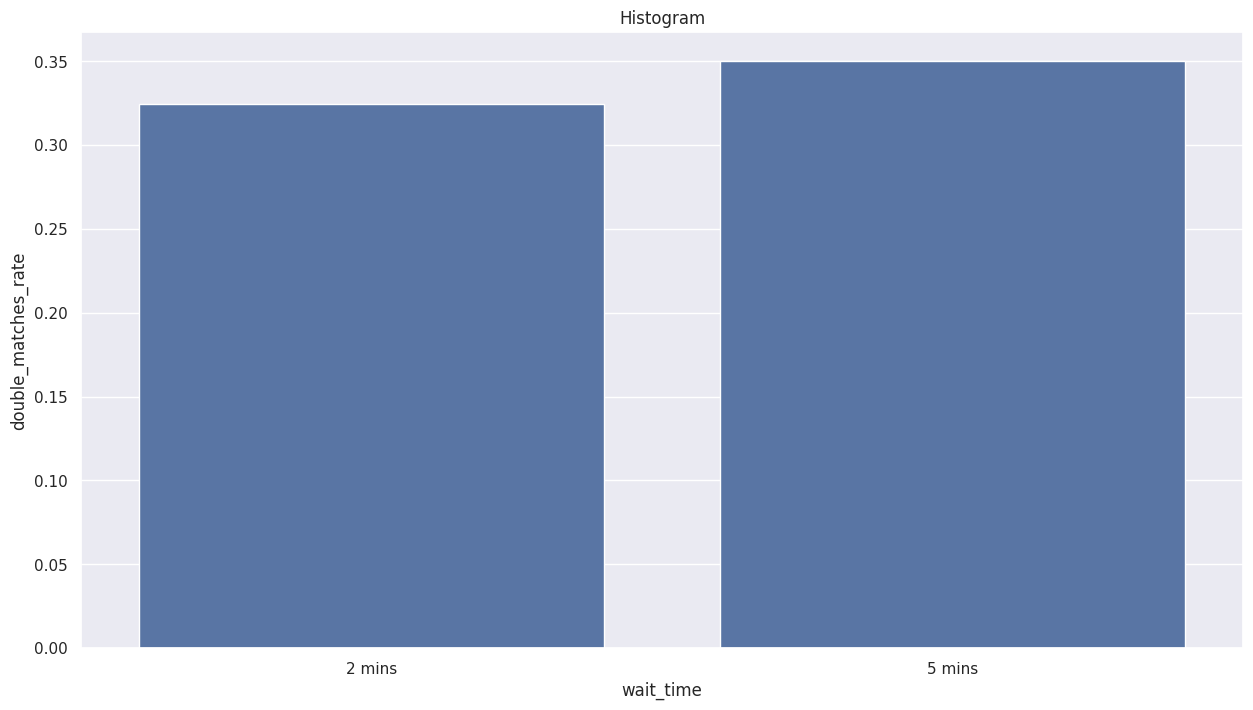

In [13]:
df_q3 = df_raw.groupby(['wait_time'])['trips_express_pool','trips_pool','total_matches','total_double_matches'].sum().reset_index()
df_q3['total_ride'] = df_q3['trips_express_pool'] + df_q3['trips_pool']
df_q3['double_matches_rate'] = df_q3['total_double_matches']/df_q3['total_ride']
sns.barplot(y=df_q3['double_matches_rate'],x=df_q3['wait_time'])
plt.title('Histogram')
plt.show()


In [34]:

df = df_raw.copy()
df['total_ride'] = df_raw['trips_express_pool'] + df_raw['trips_pool']
df['double_matches_rate'] = df['total_double_matches']/df['total_ride']



Shapiro-Wilk test is: 0.989, P-value=0.412


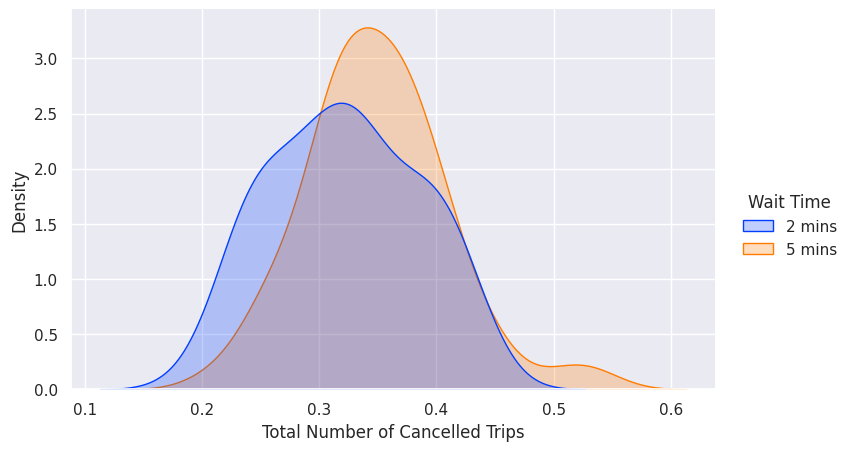

In [37]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 1)
# Create visualizetion
g = sns.displot(data=df, x='double_matches_rate', hue='wait_time', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
g.figure.subplots_adjust(top=0.9);
g._legend.set_title('Wait Time')
g.set(xlabel='Double Match Rate', ylabel='Density')

Firstly we want to test whether the double matches rate follows normal distribution.

- H0: Distribution of observations follows Normal distribution.
- H1: Distribution of observations does not follows Normal distribution.

In [38]:

statistic, p_value = stats.shapiro(df['double_matches_rate'])

print('Shapiro-Wilk test is: %.3f, P-value=%.3f' %(statistic,p_value))

Shapiro-Wilk test is: 0.989, P-value=0.412


The result shows that P value is larger than 0.05, which means distribution of observations follows normal distribution.

Now we can use parametric method to analyze the difference between a double match rate of 2-minute wait time against a 5-minute wait time.

- H0: Increasing the wait time will not increase double match rate.
- H1: Increasing the wait time will increase double match rate.

In [54]:

statistic,p_value = stats.ttest_ind(df[df['treat'] == True]['double_matches_rate'],df[df['treat'] == False]['double_matches_rate'], alternative='greater')
print('t-Statistics is: %.3f, P-value=%.3f' %(statistic,p_value))

t-Statistics is: 2.482, P-value=0.007


Conclusion:
p_value is less than 0.05. We reject the H0 with 95% confidence, which means increasing the wait time will increase double match rate.

#Q4
How do the results of cancellation rate of 2-minute against a 5-minute wait time change during commute hours ? Use simple linear regression to answer the question. Use visualization to support your results.

In [22]:

df_q4 = df_raw[df_raw['commute']==True] #Slice the data

#create some variables for use below
df_q4['total_ride'] = df_q4['trips_express_pool'] + df_q4['trips_pool']
df_q4['cancel_rate'] = df_q4['rider_cancellations']/df_q4['total_ride']

We want to verify if the cancel rate did become bigger if we introduce 5 min wait time, therefore I use one-sided regression.

In [43]:

res = linregress(df_q4['treat'], df_q4['cancel_rate'], alternative="greater")

res.pvalue

1.008812734579413e-06

Conclusion:
p_value is significantly less than 0.05. With 95% confidence, we can say that which means cancel rate did become bigger when we introduce 5-min wait time.

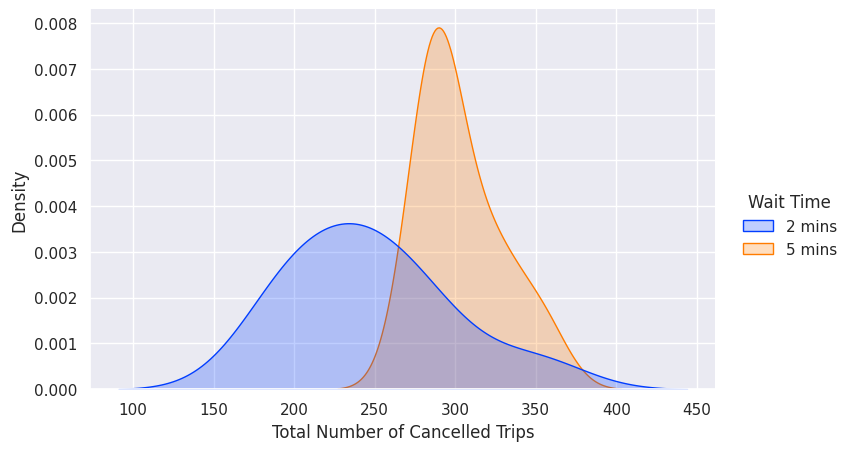

In [35]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 1)
# Create visualizetion
g = sns.displot(data=df_q4, x='rider_cancellations', hue='wait_time', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
g.figure.subplots_adjust(top=0.9);
g._legend.set_title('Wait Time')
g.set(xlabel='Total Number of Cancelled Trips', ylabel='Density')

From the visualization, we can observe clearly that the distribution of wait-time = 5 mins apparently shifted to the larger direction when compared with 2 mins wait-time, which confirms our result.

#Q5
5.  Based on the data available to you, what would you recommend doing? Would you increase the wait time from 2 to 5 minutes in the six treatment cities of the launch experiment? (explain in words)

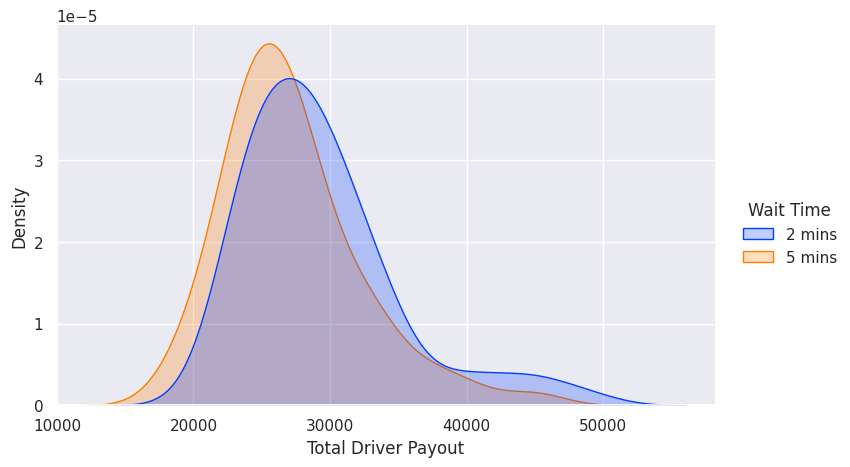

In [49]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set(font_scale = 1)
# Create visualizetion
g = sns.displot(data=df, x='total_driver_payout', hue='wait_time', kind='kde', fill=True, palette=sns.color_palette('bright')[:2], height=5, aspect=1.5)
g.figure.subplots_adjust(top=0.9);
g._legend.set_title('Wait Time')
g.set(xlabel='Total Driver Payout', ylabel='Density')

From the graph we can see that actually the longer wait reduced total driver payout. Now we want to test whether this decrease is statistically significant.

Following the same procedure we first verify if it's normally distributed:

In [58]:

statistic, p_value = stats.shapiro(df['total_driver_payout'])

print('Shapiro-Wilk test is: %.3f, P-value=%.3f' %(statistic,p_value))

Shapiro-Wilk test is: 0.904, P-value=0.000


P-value is less than 0.05, which means it's not normally distributed, we can Whitney U test to decide whether the median are the same:

- H0: Driver payout does not decrease with 5 min wait.
- H1: Driver payout does decrease with 5 min wait.




In [60]:

u_statistic, p_value = stats.mannwhitneyu(df[df['treat'] == True]['total_driver_payout'],df[df['treat'] == False]['total_driver_payout'], alternative='less')
print('U-Statistics is: %.3f, P-value=%.3f' %(u_statistic,p_value))

U-Statistics is: 1529.000, P-value=0.013


Conclusion:

- With P-value smaller than 0.05, we reject the null hypothesis and conclude that driver payout will decrease with the 5 min wait.
- Therefore, we should not increase the wait to 5 min wait because it will increase the cancellation rate and negatively affect our contractors(drivers) income, which seems to be a "double lose" situation where both our riders and drivers are not happy.